# [다중공선성과 변수 선택]

다중 공선송은 독립변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있는 경우를 의미한다.
독립 변수들이 서로 독립이 아니라 상호 상관관계가 강한 경우에 발생한다.
이것은 독립 변수의 공분산 행렬이 full rank이어야 한다는 조건을 침해한다.
결국 분석의 결과를 신뢰할 수 없는 문제가 발생할 수 있다.

이번 데이터는 미국의 거시경제지표를 나타낸 것이다. 각 항목의 의미는 다음과 같다.

    TOTEMP - Total Employment

    GNPDEFL - GNP deflator

    GNP - GNP

    UNEMP - Number of unemployed

    ARMED - Size of armed forces

    POP - Population

    YEAR - Year (1947 - 1962)


In [18]:
#필요한 각종 라이브러리들을 선언한다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from statsmodels.datasets.longley import load_pandas

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


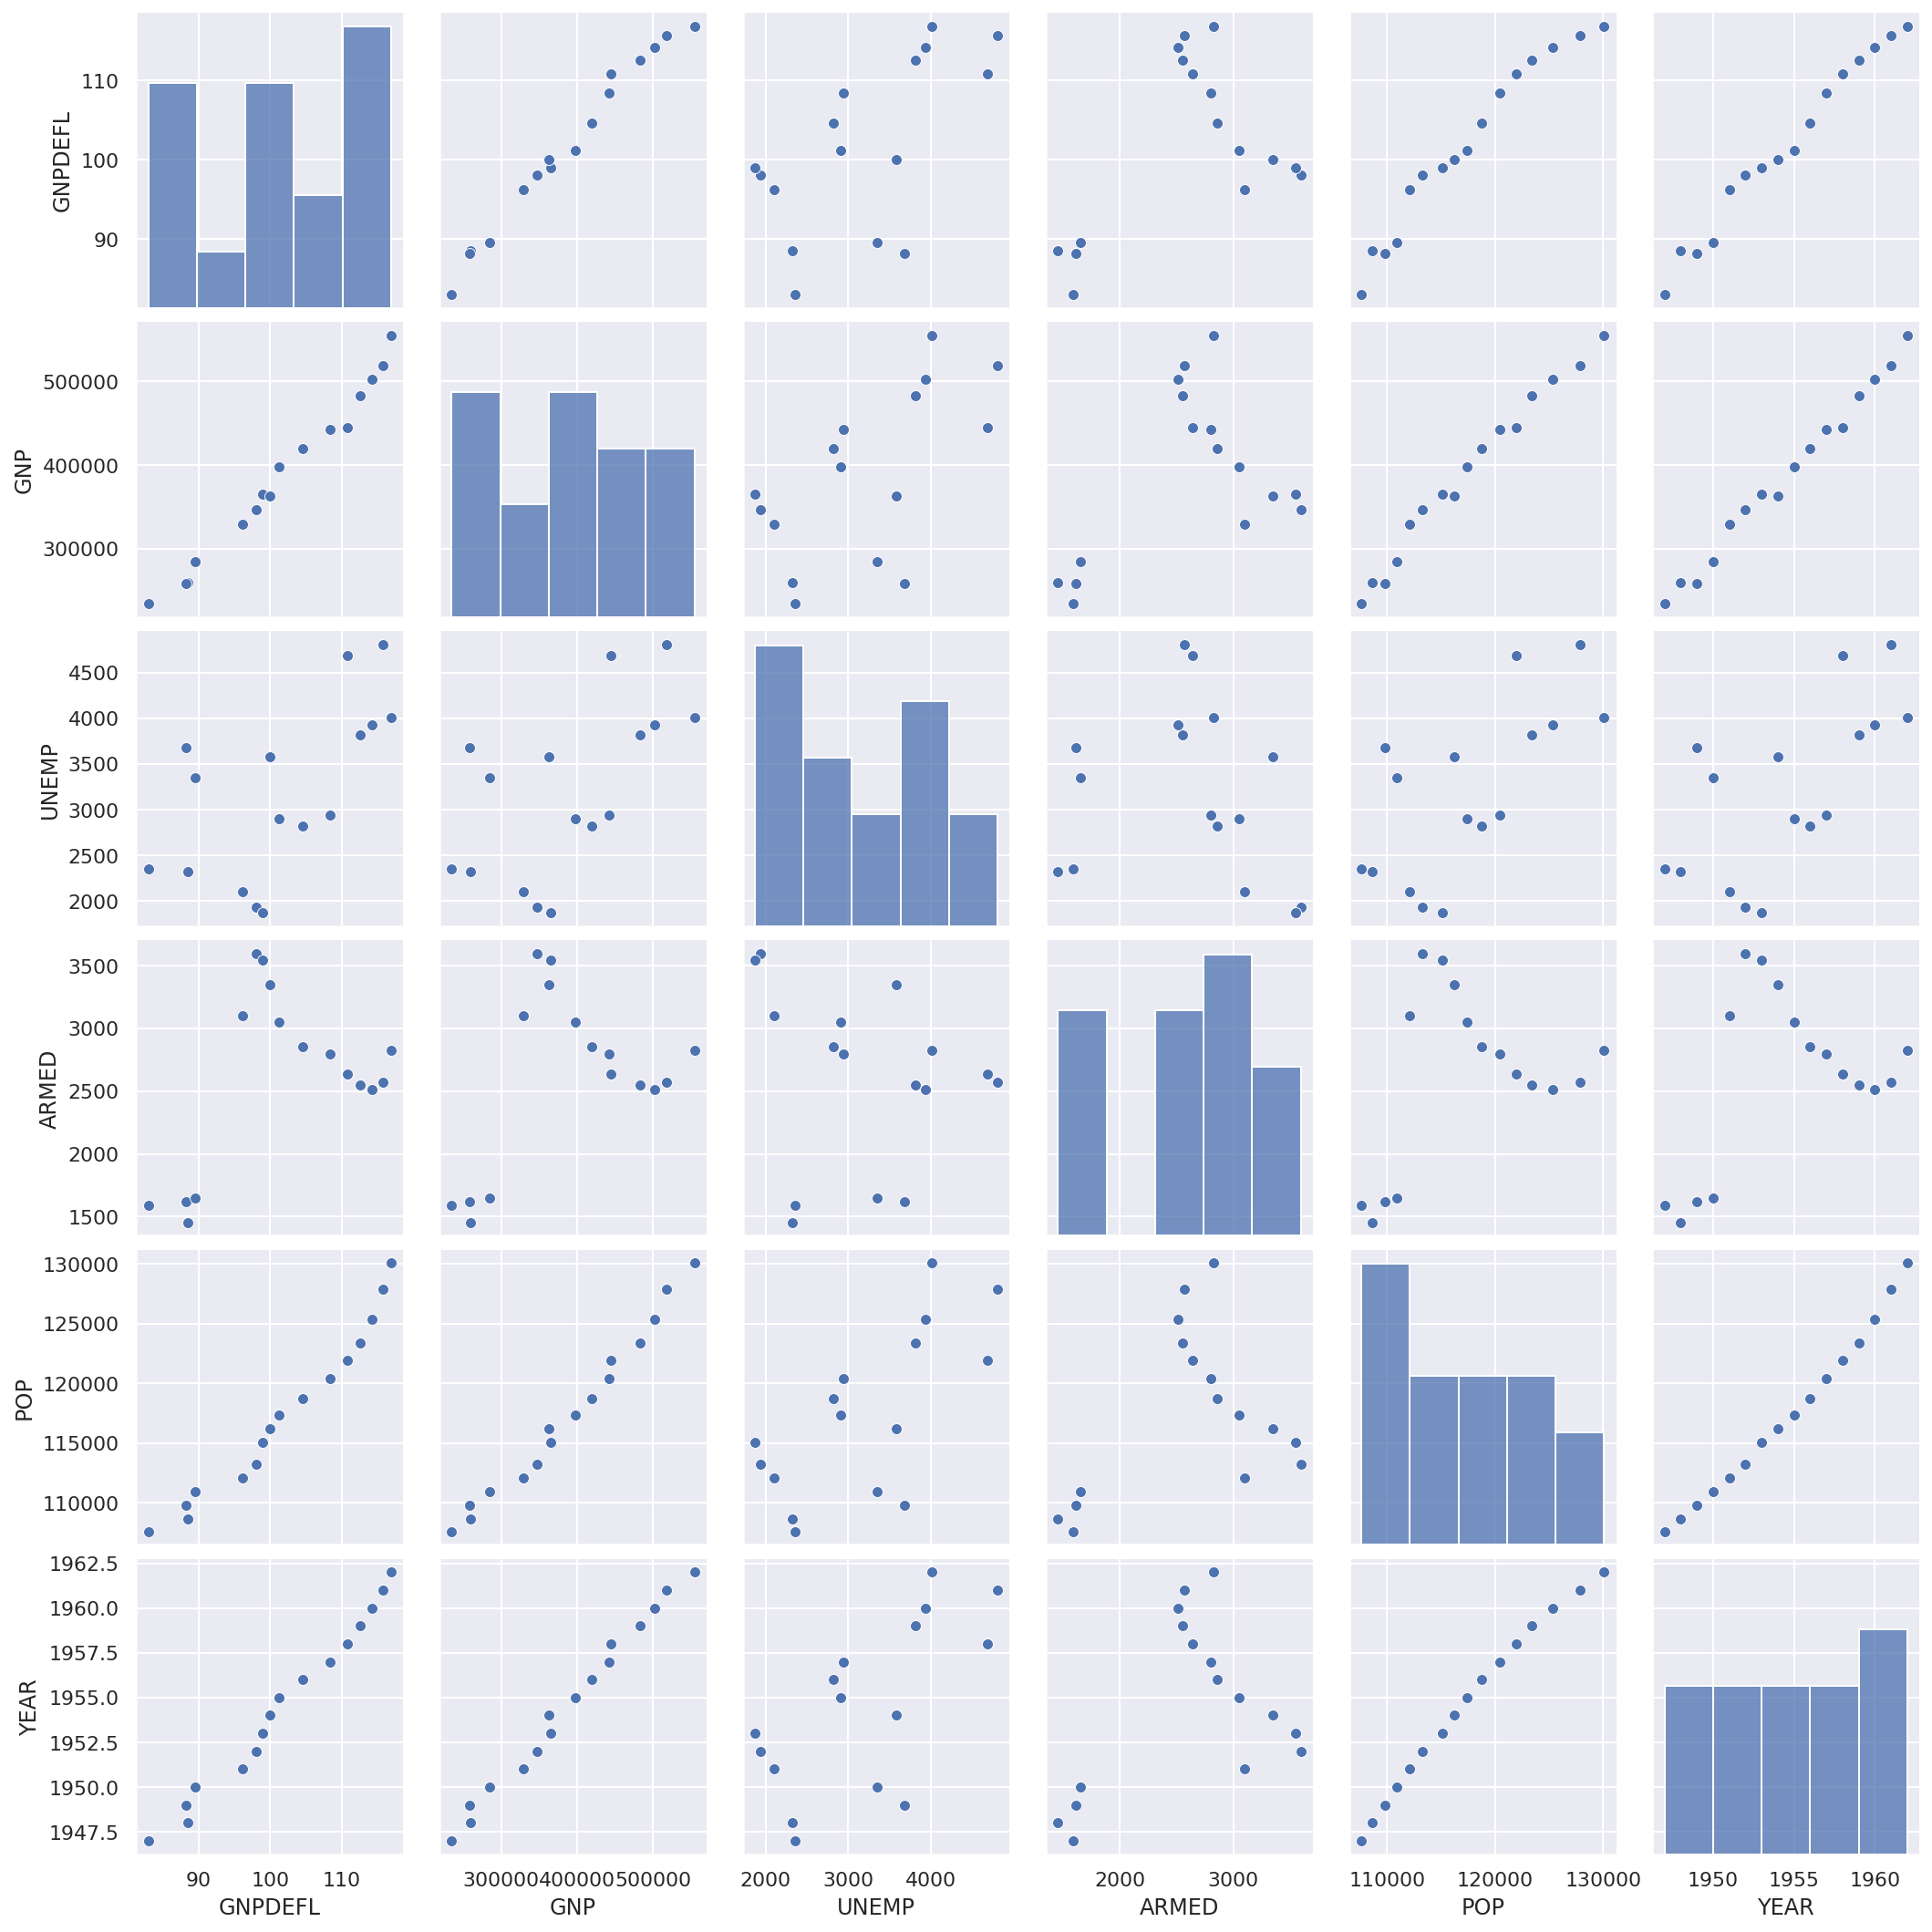

In [20]:
#독립변수간 상관 관계를 알아보기 위해 다양한 방식으로 그래프를 출력해본다.
dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

In [22]:
#상관관계를 수치로 확인하기 위해 상관계수 행렬로 출력해 본다.
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


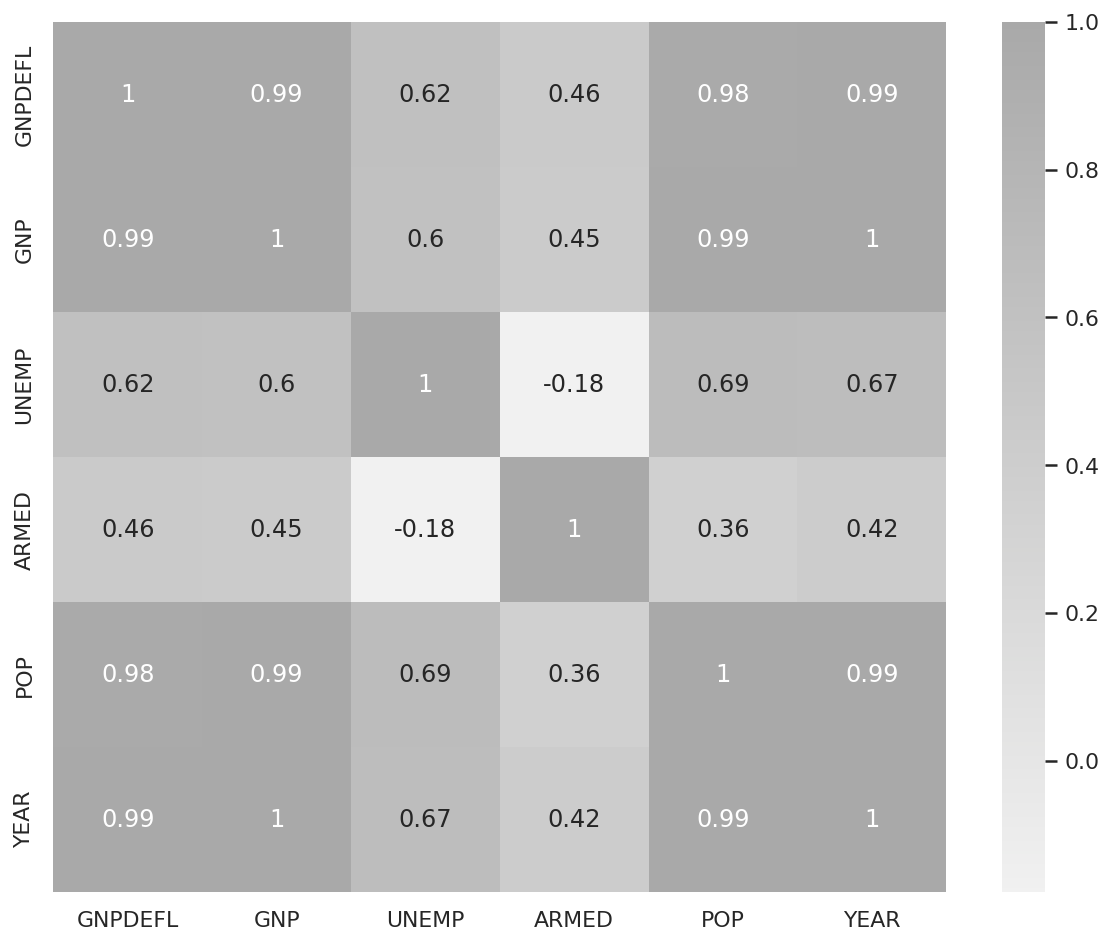

In [23]:
#상관계수를 heatmap을 통해 알아본다.
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

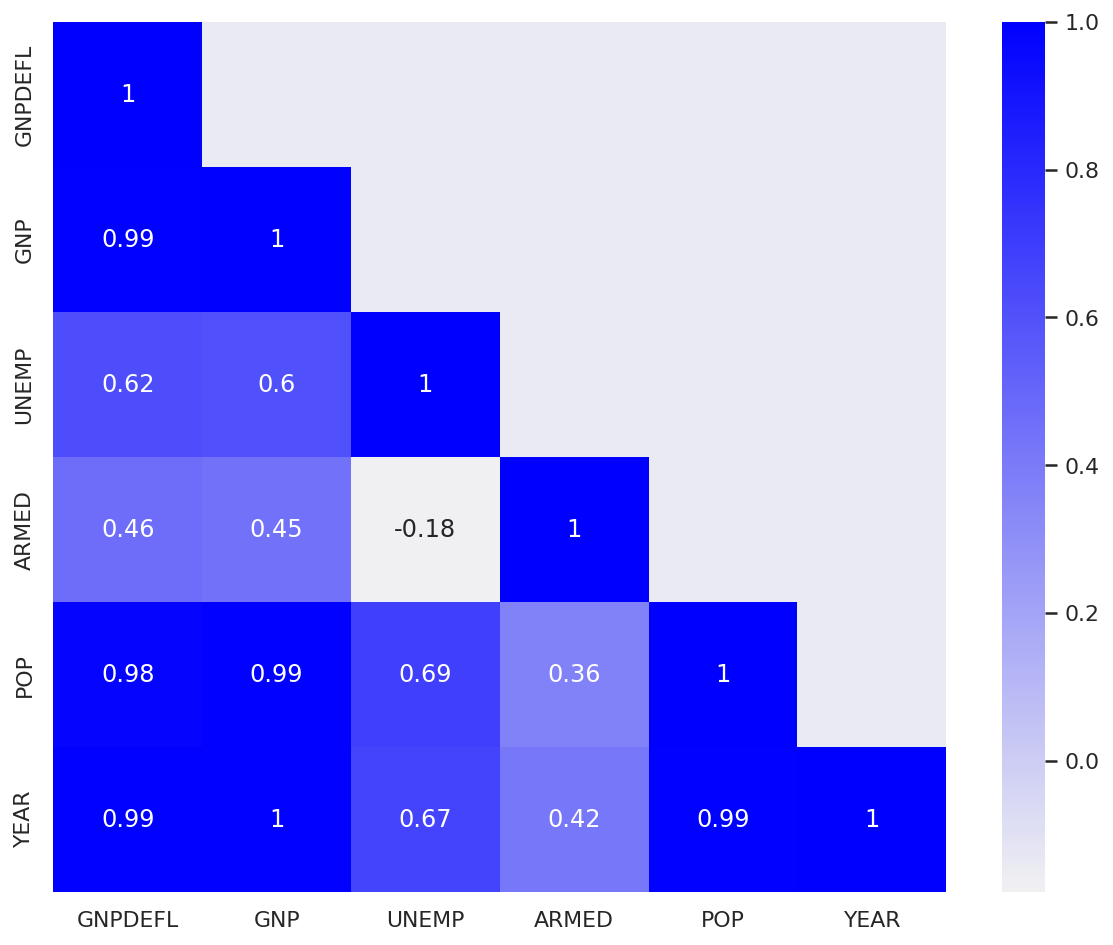

In [25]:
from statsmodels.datasets.longley import load_pandas

dfy = load_pandas().endog # 종속변수 이름: TOTEMP
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)

corr_M = dfX.corr() # 독립변수 상관관계
mask = np.array(corr_M)
mask[np.tril_indices_from(mask)] = False

plt.figure(figsize= (10,8))

sns.heatmap(corr_M, 
            cmap = sns.light_palette("Blue", as_cmap=True),
            annot = True, 
            mask = mask)

plt.show()

위의 표에서와 같이 독립 변수간의 상관관계가 강한 경우가 많다. 즉, 강한 다중 공선성이 존재함을 알 수 있다.

다중 공선성이 있을때는 Cond. No.의 값이 올라간다. 우리가 이 값을 쉽게 확인하기 위해 OLS 알고리즘을 수행해 값을 알아 본다.

In [26]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())

#Cond. No. 값이 매우 높으며, 이 값이 높다는 의미는 다중공선성이 존재한다는 의미다.

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Wed, 15 Dec 2021   Prob (F-statistic):             0.0366
Time:                        06:00:14   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

In [27]:
#R2의 값을 찍어서 결과를 비교하자.

from sklearn.metrics import r2_score

test1 = []

for i in range(10):
    df_train, df_test, result = get_model1(i)
    
    pred_test = result.predict(df_test)
    rsquared = r2_score(df_test.TOTEMP, pred_test)
    test1.append(round(rsquared,3))

test1

[0.982, 0.974, 0.988, 0.759, 0.981, 0.894, 0.88, 0.931, 0.861, 0.968]

위의 회귀분석 결과를 보면 알 수 있듯이 다중 공선성이 존재하면, 조건수도 많아 지게 되는 것을 알 수 있다.
여기서, train data로 학습한 회귀 모형이 결정계수가 '1'로서 100%로 나왔다.

다중공선성의 가장 우선적인 문제점은 과최적화이다. 
즉, train data se에서 결정계수는 1이었으나, test에서 모두 train보다 결정계수가 낮게 나왔다.
원래 test에서의 값인 예측값이 train 값보다 낮긴 하지만, 그 차가 큰 과적합의 문제가 있다면 크게 성능을 좌우한다,

# [다중 공선성 해결법]

변수 선택법으로 의존적인 변수 삭제

PCA(principal component analysis) 방법으로 의존적인 성분 삭제

정규화(regularized) 방법 사용 (여기선 정규화라고 칭했지만 보통 규제라고 표현한다.)

# 분산팽창계수(VIF)

다중 공선성을 없애는 가장 기본적인 방법은 다른 독립변수에 의존하는 변수를 없애는 것이다.

가장 의존적인 독립변수를 선택하는 방법으로는 VIF(Variance Inflation Factor)를 사용할 수 있다.

     VIF는 특정 독립변수를 나머지 독립변수로 적합했을 때 성능을 나타낸 것이다.

     다른 변수에 의존할수록 VIF 값이 높다.

statsmodels.stats.outliers_influence의 variance_inflation_factor()를 이용하여 VIF를 계산할 수 있다.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

lst = []

# 독립변수의 갯수 만큼 반복
for i in range(dfX.shape[1]):
    v = variance_inflation_factor(dfX.values, i) # 컬럼을 정수로 지정한다.
    lst.append(v)
    
vif["VIF Factor"] = lst
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


각 독립변수의 VIF계수를 확인하였고, 이중 VIF 계수가 작은 순으로 변수를 골라 사용하였다.

In [30]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.8, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNP + ARMED + UNEMP", data=df_train)
    
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 15 Dec 2021   Prob (F-statistic):                nan
Time:                        06:13:42   Log-Likelihood:                 59.095
No. Observations:                   3   AIC:                            -112.2
Df Residuals:                       0   BIC:                            -114.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0114        inf          0        n

VIF계수가 작은 GNP, ARMED, UNEMP만을 사용하였을 때 여전히 조건수가 많지만 이전보다 줄어든 것을 알 수 있다.

In [34]:
df_train.std()

TOTEMP      1161.757863
GNPDEFL        3.601851
GNP        22656.487084
UNEMP         58.799093
ARMED        130.678996
POP         1532.127388
YEAR           1.000000
dtype: float64

변수별 단위차가 있어 스케일링이 필요하다.

In [35]:
def get_model3(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result3 = get_model3(3)
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           0.000231
Time:                        06:18:02   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

스케일링으로 인해 조건수가 4.77로 크게 감소하였다.

여기서는 train으로 학습한 회귀모형의 결정계수가 0.989로 나타났다.

In [36]:
from sklearn.metrics import r2_score

test2 = []

for i in range(10):
    df_train, df_test, result = get_model3(i)
    
    pred_test = result.predict(df_test)
    rsquared = r2_score(df_test.TOTEMP, pred_test)
    test2.append(round(rsquared,3))

test2

[0.976, 0.984, 0.969, 0.94, 0.977, 0.956, 0.98, 0.992, 0.984, 0.979]

train에서의 결정계수 0.989와 test 결정계수가 어느정도 비슷하게 나타나 이전보다 차이가 줄었다.

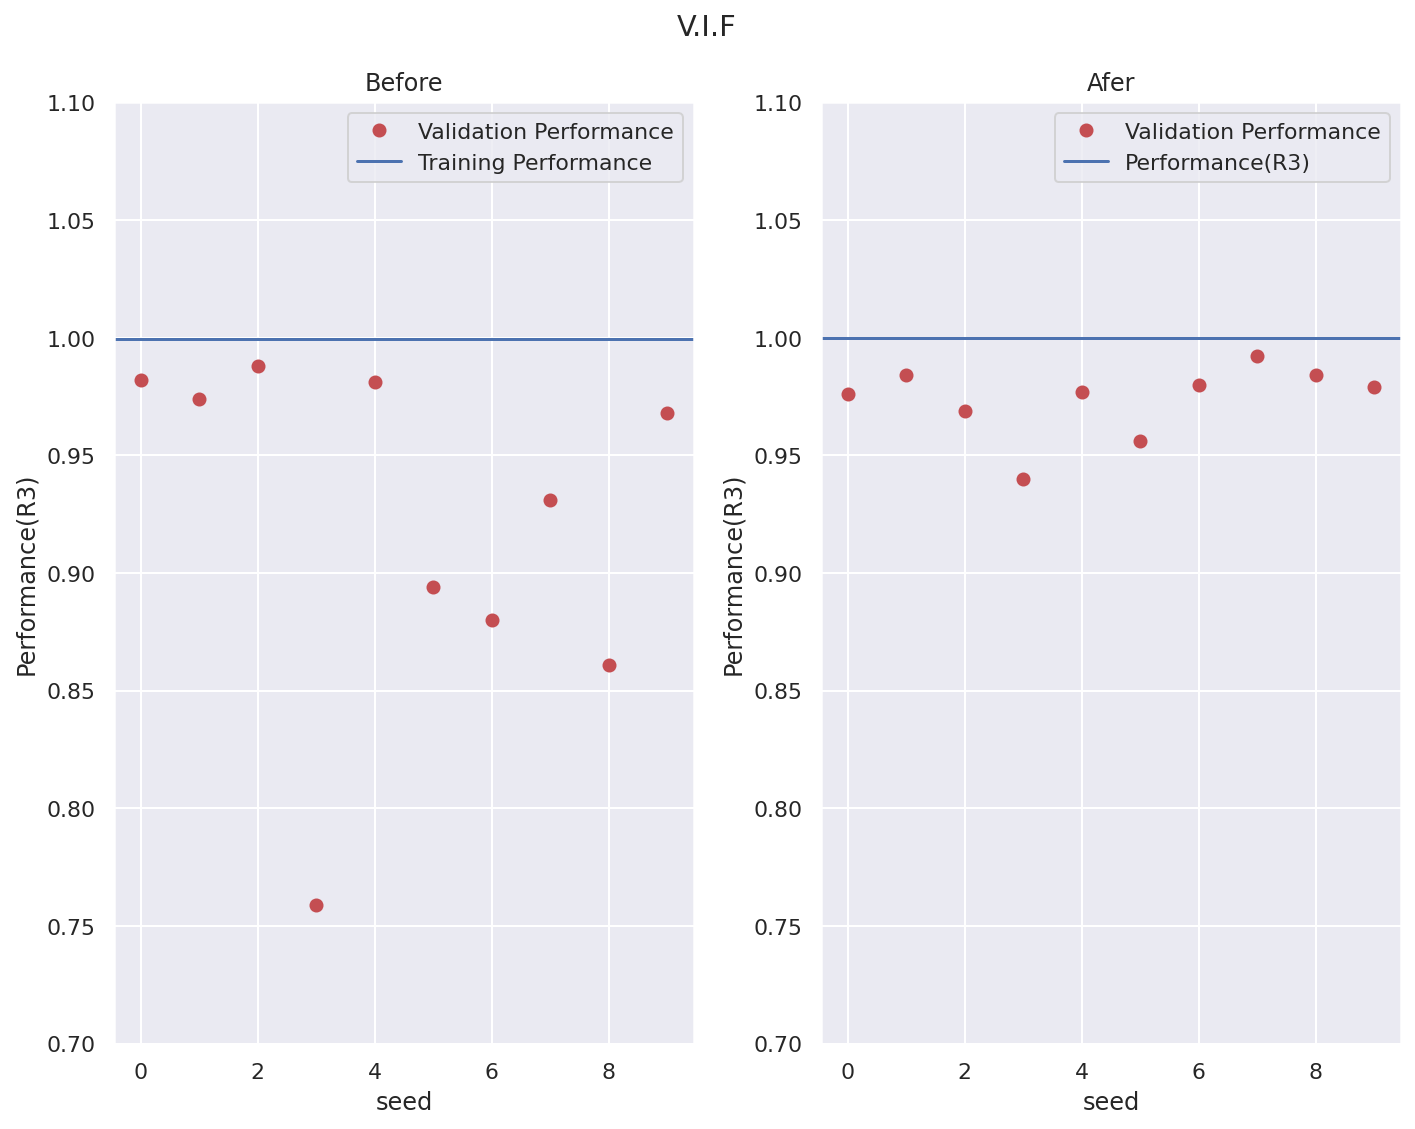

In [40]:
plt.subplot(121)
plt.plot(test1, 'ro', label="Validation Performance")
plt.axhline(result1.rsquared, label="Training Performance")
plt.legend()
plt.xlabel("seed")
plt.ylabel("Performance(R3)")
plt.title("Before")
plt.ylim(0.7, 1.1)

plt.subplot(122)
plt.plot(test2, 'ro', label="Validation Performance")
plt.axhline(result2.rsquared, label="Performance(R3)")
plt.legend()
plt.xlabel("seed")
plt.ylabel("Performance(R3)")
plt.title("Afer")
plt.ylim(0.7, 1.1)

plt.suptitle("V.I.F")
plt.tight_layout()
plt.show()